# Introduction au Crawling 

In [1]:
import requests # Récupérer les pages web
from bs4 import BeautifulSoup # Scraping
from urllib.parse import urljoin # Reconstruction d'URLs (pour les relatives)
import networkx as nx # Génération et analyse de réseau

In [72]:
# URLs de départ du crawl
START_URLS = [
    'https://quentin-monmousseau.netlify.com/'
]

# Niveau max de profondeur
MAX_DEPTH = 1

# =============================================================================
# Script
# =============================================================================

# La queue de traitement des pages à visiter
# Plus d'info sur les files FIFO (first in, first out):
# https://fr.wikipedia.org/wiki/File_(structure_de_donn%C3%A9es)
# Ici, nous implémentons cette structure de données à l'aide d'une list
# dont nous allons extraire le premier élément. Ce n'est pas la manière
# optimiale de faire, mais cela suffit largement pour notre exemple.
queue = []

# Le réseau des pages que nous allons constituer
# C'est un `DiGraph` car c'est un réseau dirigé (une url pointe vers une autre
# dans un seul sens).
graph = nx.DiGraph()

# Peuplons la queue avec les urls de départ.
# Pour pouvoir traquer la profondeur à laquelle nous avons trouvé une url
# durant le crawl, nous allons représenter nos tâches de crawl (visiter une
# page), comme un tuple contenant 1) l'url à visiter, 2) la profondeur.
# Exemple: (http://google.fr, 2)
for url in START_URLS:
    queue.append((url, 0))

# Traitons désormais les tâches de notre queue à l'aide d'une boucle
# La condition `len(queue)` signifie: tant qu'il y a des tâches dans la
# queue de traitement, nous itérons.
while len(queue):

    # Récupérons l'url à visiter et la profondeur de cette url dans le crawl
    # Note: en python il est possible de "unpack" un tuple:
    # year, name = (2009, 'François')
    # Note: `.pop(0)` veut dire, donne moi le premier élement de la liste
    # et retire-le de celle-ci.
    url, depth = queue.pop(0)

    print('Level [%i]: %s' % (depth, url))

    # Récupérons le HTML de la page avec requests
    r = requests.get(url)

    # Peut-être que ceci a échoué (code 400, 500 etc.), auquel cas, continuons
    # la boucle. Le mot-clé `continue` permet de passer directement à la
    # prochaine itération de la boucle
    if r.status_code >= 400:
        continue

    # Si la requête n'a pas renvoyé du HTML, nous ne pouvons pas en extraire
    # les liens hypertexte
    if 'html' not in r.headers['content-type']:
        continue

    # Maintenant, parsons le HTML avec beautifulsoup
    soup = BeautifulSoup(r.text, 'html.parser')

    # Iterons sur les liens de la page
    all_links_count = 0
    relevant_links_count = 0
    for link in soup.find_all('a'):
        href = link.get('href')
        all_links_count += 1

        # Certains tags n'ont pas de href, cela peut arriver. Le web est sale.
        if href is None:
            continue

        # Si le lien commence par '#' c'est une ancre interne et nous ne
        # voulons pas revisiter la même page.
        if href.startswith('#'):
            continue

        # Si le lien commence par 'javascript:' ou 'mailto:', nous n'en voulons
        # pas. Il existe d'autres exceptions, ce ne sont que deux exemples
        if href.startswith('javascript:') or href.startswith('mailto:'):
            continue

        # Maintenant, nous avons besoin de résoudre l'url cible car celle-ci
        # peut-être relative
        target_url = urljoin(url, href)

        relevant_links_count += 1

        # Ajoutons notre relation au réseau
        graph.add_edge(url, target_url)

        # Ajoutons l'url à la queue de traitement si nous pouvons encore
        # descendre en profondeur et si elle n'existe pas déjà crawlée dans
        # notre réseau
        already_crawled = target_url in graph and graph.out_degree(target_url) > 0

        if depth < MAX_DEPTH and not already_crawled:
            queue.append((target_url, depth + 1))

    print('   Found %i relevant links' % relevant_links_count)
    print('   Found %i irrelevant links' % (all_links_count - relevant_links_count))

Level [0]: https://quentin-monmousseau.netlify.com/
   Found 26 relevant links
   Found 2 irrelevant links
Level [1]: https://quentin-monmousseau.netlify.com/tags/data-science/
   Found 16 relevant links
   Found 2 irrelevant links
Level [1]: https://quentin-monmousseau.netlify.com/tags/cognitive-science/
   Found 16 relevant links
   Found 2 irrelevant links
Level [1]: https://quentin-monmousseau.netlify.com/tags/sports-science/
   Found 16 relevant links
   Found 2 irrelevant links
Level [1]: https://twitter.com/QMonmousseau
   Found 88 relevant links
   Found 12 irrelevant links
Level [1]: https://www.linkedin.com/in/quentin-monmousseau
Level [1]: https://github.com/qmonmous
   Found 84 relevant links
   Found 1 irrelevant links
Level [1]: http://www.deerzign.com
   Found 3 relevant links
   Found 3 irrelevant links
Level [1]: https://twitter.com/QMonmousseau
   Found 88 relevant links
   Found 12 irrelevant links
Level [1]: https://www.linkedin.com/in/quentin-monmousseau
Level [1]:

In [73]:
print(nx.info(graph))

Name: 
Type: DiGraph
Number of nodes: 158
Number of edges: 236
Average in degree:   1.4937
Average out degree:   1.4937


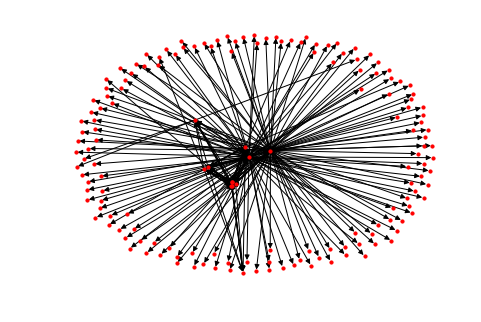

In [74]:
nx.draw(graph, with_labels=False, node_size=10)

### Limites de la visualisation avec NetworkX

La librairie NetworkX permet de faire de nombreux calculs statistiques utiles pour étudier le réseau. Toutefois, elle ne permet pas de le visualiser confortablement. Pour se faire, on lui préfère des outils tels que [Gephi](https://gephi.org/) (un peu vieillot) ou [Manylines](http://tools.medialab.sciences-po.fr/manylines/app/#/upload) (développé récemment par le MediaLab de SciencesPo Paris) par exemple.  
Pour analyser notre réseau à l'aide de ces outils, il est nécessaire de l'exporter au format .gexf grâce à NetworkX.

In [ ]:
# Export du réseau au format .gexf
nx.write_gexf(graph, 'crawl.gexf')